# Elevation from NOAA NGDC GLOBE data set

## Overview

- **Key ideas:**
    - Intensive operations that use a lot of RAM memory. Run this notebook inside aerossol server.
    - Description: NOAA NGDC GLOBE: Gridded 1-km, quality controlled global Digital Elevation Model (DEM) data from the Global Land One-km Base Elevation (GLOBE) Project.
    - Explore South America topography.
    - Regrid and export elevation data in the same spatial and temporal grid of GIMMS NDVI 3g data set for South America.
    - Data distribution for NDVI and elevation.
- **References:**
    - [Website](https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NGDC/.GLOBE/).

## Initial setup

In [1]:
# Load packages.
import os
import sys
import glob
import warnings

import numpy as np
import xarray as xr
import xesmf as xe
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import cartopy.crs as ccrs

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy import feature as cfeature
from cartopy.io import shapereader
from dask.diagnostics import ProgressBar

warnings.filterwarnings("ignore")
xr.set_options(display_style="text")
%matplotlib inline

In [2]:
print(">>> Versions:")
print("* numpy:", np.__version__)
print("* xarray:", xr.__version__)
print("\n>>> Computer:")
!echo "* Hostname: ${HOSTNAME}"
!echo "* User: ${USER}"
!echo "* Directory: $(pwd)"
!echo "* Date: $(date)"
!echo "* CPUs: $(nproc)"

>>> Versions:
* numpy: 1.19.1
* xarray: 0.16.0

>>> Computer:
* Hostname: n007
* User: sandroal
* Directory: /work/sandroal/notebooks/single_variables
* Date: Tue Nov 17 13:51:25 BRST 2020
* CPUs: 40


In [3]:
%%time

# My repository.
repository = "/work/sandroal/cdlearn/"

# Include once my repository in the path for searching libraries.
if repository not in sys.path:
    sys.path.append(repository)
    
# Import my package.
import cdlearn

CPU times: user 1.89 s, sys: 396 ms, total: 2.28 s
Wall time: 2.95 s


In [4]:
# Map borders for South America.
loni, lonf, lati, latf = -90, -30, -60, 20

# Final results.
save_fig = True

# Data files location.
FIG_FOLDER = "/work/sandroal/images/single_variables/"

In [5]:
%%time

# First we will use cartopy's shapereader to download (and cache) states shapefile with 50 
# meters resolution from the NaturalEarth.
kw = dict(resolution="50m", category="cultural", name="admin_1_states_provinces")
states_shp = shapereader.natural_earth(**kw)
shp = shapereader.Reader(states_shp)

CPU times: user 36 ms, sys: 0 ns, total: 36 ms
Wall time: 37.9 ms


## Preprocess elevation data

In [6]:
# Find data.
FILE_PATH = "/work/sandroal/data_sets/GLOBE/data.nc"

# Not lazy read.
DS = xr.open_dataset(filename_or_obj=FILE_PATH).compute()

# Rename coordinates and variable.
DS = DS.rename({"topo": "elevation", "X": "lon", "Y": "lat"})

# # Latitude in ascending order.
DS = DS.sortby(DS.lat)

# South America.
DS = DS.sel(lat=slice(lati, latf), lon=slice(loni, lonf))

# Information.
print(">>> Size in GB:", DS.nbytes / 1e9)

# Dataset object.
print("\n>>> Dataset:", DS)

>>> Size in GB: 0.2765472

>>> Dataset: <xarray.Dataset>
Dimensions:    (lat: 9600, lon: 7200)
Coordinates:
  * lon        (lon) float32 -89.995834 -89.9875 ... -30.0125 -30.004168
  * lat        (lat) float32 -59.995834 -59.9875 ... 19.987501 19.995834
Data variables:
    elevation  (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan


CPU times: user 1min 45s, sys: 5.57 s, total: 1min 50s
Wall time: 1min 50s


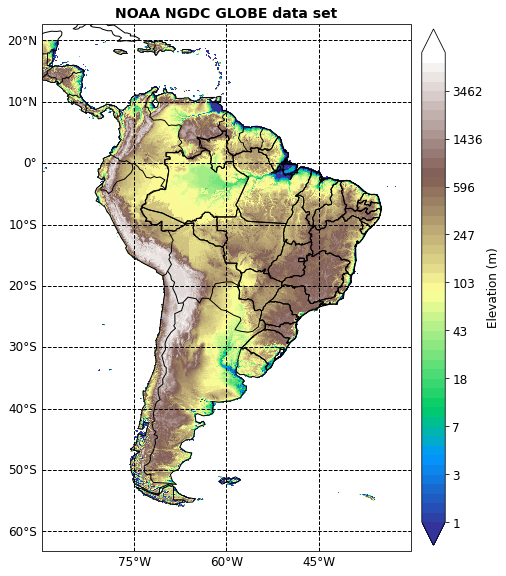

In [7]:
%%time

# Set figure size, projection, and extent.
fig = plt.figure(figsize=(8, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([loni, lonf, lati, latf]) 

# Add coastlines and formatted gridlines.
ax.coastlines(resolution="110m", linewidth=1)
gl = ax.gridlines(
    crs=ccrs.PlateCarree(), 
    draw_labels=True, 
    linewidth=1, 
    color="black", 
    linestyle="--"
)
ax.add_feature(cfeature.BORDERS)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlines = True
gl.ylocator = mticker.FixedLocator(np.arange(-60, 20 + 10, 10))
gl.xlocator = mticker.FixedLocator(np.arange(-90, -30 + 15, 15))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {"size": 12, "color": "black"}
gl.ylabel_style = {"size": 12, "color": "black"}

# Draw the plot.
p = DS.elevation.plot(
    ax=ax,
    vmin=0.1,
    vmax=7000,
    levels=10**np.linspace(0.1, np.log10(7000), 50),
    cmap=plt.cm.terrain,
    add_colorbar=False,
    add_labels=False
)

# Brazilian states's boundaries.
for state in shp.geometries():
    ax.add_geometries(
       geoms=[state], 
       crs=ccrs.PlateCarree(), 
       facecolor="none", 
       edgecolor="black"
    )

# Adjustments.
plt.title(f"NOAA NGDC GLOBE data set", weight="bold", size=14)
cb = plt.colorbar(
    mappable=p, 
    ax=ax, 
    orientation="vertical", 
    pad=0.025, 
    shrink=0.95,
    extend="both"
)
cb.set_label("Elevation (m)", size=12)
cb.ax.tick_params(labelsize=12)

if save_fig:
    plt.savefig(
        FIG_FOLDER + "elevation.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )

## Regrid and export data

In [8]:
%%time 

# Load NDVI data into memory.
DS_NDVI = xr.open_dataset(
    filename_or_obj="/work/sandroal/data_sets/GIMMS/ppdata_ndvi.nc"
).load()

# Show it.
print(DS_NDVI)

<xarray.Dataset>
Dimensions:    (lat: 960, lon: 720, time: 828)
Coordinates:
    land_mask  (lat, lon) bool False False False False ... False False False
  * lon        (lon) float64 -89.96 -89.88 -89.79 ... -30.21 -30.13 -30.04
  * lat        (lat) float64 -59.96 -59.88 -59.79 -59.71 ... 19.79 19.88 19.96
  * time       (time) datetime64[ns] 1981-07-01 1981-07-15 ... 2015-12-15
Data variables:
    ndvi       (time, lat, lon) float32 -0.3 -0.3 -0.3 -0.3 ... -0.3 -0.3 -0.3
Attributes:
    FileName:              ndvi3g_geo_v1_1981_0712.nc4
    Institution:           NASA/GSFC GIMMS
    Data:                  NDVI3g version 1
    Reference:             1. Pinzon, J.E.; Tucker, C.J.                     ...
    CommentsVersion1:      version1 includes two major fixes (a and b), and t...
    Temporalrange:         1981-07-01 -> 2015-12-31
    Year:                  1981.0
    RangeSemester:         Jul 1 - Dec 31 (7:0.5:12.5)
    SpatialResolution:     1/12 x 1/12 degrees
    TemporalResolut

In [9]:
# In accordance with GIMMS NDVI 3g original spatial grid.
NEW_GRID = xr.Dataset(
    coords={"lat": (["lat"], DS_NDVI.lat.values), 
            "lon": (["lon"], DS_NDVI.lon.values)}
)

# Show it.
print(NEW_GRID)

<xarray.Dataset>
Dimensions:  (lat: 960, lon: 720)
Coordinates:
  * lat      (lat) float64 -59.96 -59.88 -59.79 -59.71 ... 19.79 19.88 19.96
  * lon      (lon) float64 -89.96 -89.88 -89.79 -89.71 ... -30.21 -30.13 -30.04
Data variables:
    *empty*


In [10]:
%%time

# Regridder object.
REGRIDDER = xe.Regridder(
    ds_in=DS,
    ds_out=NEW_GRID,
    method="bilinear",
    periodic=False, # Not global data!
    filename="globe_to_gimms_regriddrer.nc",
    reuse_weights=True
)

Reuse existing file: globe_to_gimms_regriddrer.nc
CPU times: user 252 ms, sys: 432 ms, total: 684 ms
Wall time: 686 ms


In [11]:
%%time

# Regrid data.
DS_REG = REGRIDDER(DS, keep_attrs=True)

# Show it.
print(DS_REG)

using dimensions ('lat', 'lon') from data variable elevation as the horizontal dimensions for this dataset.
<xarray.Dataset>
Dimensions:    (lat: 960, lon: 720)
Coordinates:
  * lon        (lon) float64 -89.96 -89.88 -89.79 ... -30.21 -30.13 -30.04
  * lat        (lat) float64 -59.96 -59.88 -59.79 -59.71 ... 19.79 19.88 19.96
Data variables:
    elevation  (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    regrid_method:  bilinear
CPU times: user 80 ms, sys: 196 ms, total: 276 ms
Wall time: 274 ms


In [12]:
%%time

# Export data.
DS_REG, _ = xr.align(DS_REG, DS_NDVI)
DS_REG = DS_REG.assign_coords({"land_mask": DS_NDVI.land_mask})
ppdata_fp = "/work/sandroal/data_sets/GLOBE/ppdata_elevation.nc"
DS_REG.to_netcdf(path=ppdata_fp, mode="w")

CPU times: user 468 ms, sys: 504 ms, total: 972 ms
Wall time: 1.06 s


CPU times: user 1.78 s, sys: 60 ms, total: 1.84 s
Wall time: 1.84 s


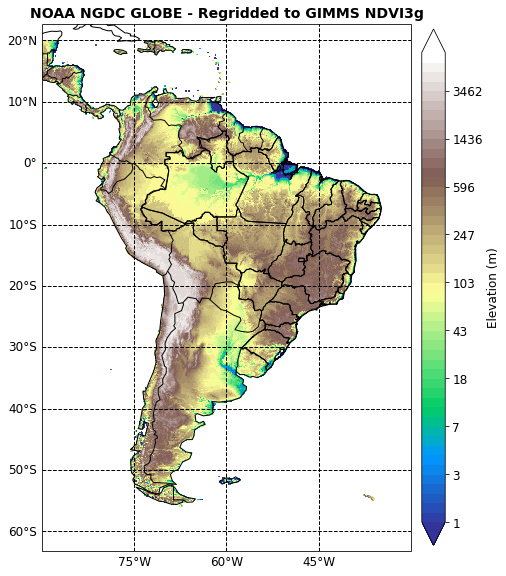

In [13]:
%%time

# Set figure size, projection, and extent.
fig = plt.figure(figsize=(8, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([loni, lonf, lati, latf]) 

# Add coastlines and formatted gridlines.
ax.coastlines(resolution="110m", linewidth=1)
gl = ax.gridlines(
    crs=ccrs.PlateCarree(), 
    draw_labels=True, 
    linewidth=1, 
    color="black", 
    linestyle="--"
)
ax.add_feature(cfeature.BORDERS)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlines = True
gl.ylocator = mticker.FixedLocator(np.arange(-60, 20 + 10, 10))
gl.xlocator = mticker.FixedLocator(np.arange(-90, -30 + 15, 15))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {"size": 12, "color": "black"}
gl.ylabel_style = {"size": 12, "color": "black"}

# Draw the plot.
p = DS_REG.elevation.plot(
    ax=ax,
    vmin=0.1,
    vmax=7000,
    levels=10**np.linspace(0.1, np.log10(7000), 50),
    cmap=plt.cm.terrain,
    add_colorbar=False,
    add_labels=False
)

# Brazilian states's boundaries.
for state in shp.geometries():
    ax.add_geometries(
       geoms=[state], 
       crs=ccrs.PlateCarree(), 
       facecolor="none", 
       edgecolor="black"
    )

# Adjustments.
plt.title(f"NOAA NGDC GLOBE - Regridded to GIMMS NDVI3g", weight="bold", size=14)
cb = plt.colorbar(
    mappable=p, 
    ax=ax, 
    orientation="vertical", 
    pad=0.025, 
    shrink=0.95,
    extend="both"
)
cb.set_label("Elevation (m)", size=12)
cb.ax.tick_params(labelsize=12)

if save_fig:
    plt.savefig(
        FIG_FOLDER + "elevation2.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )

## Bi-histograms

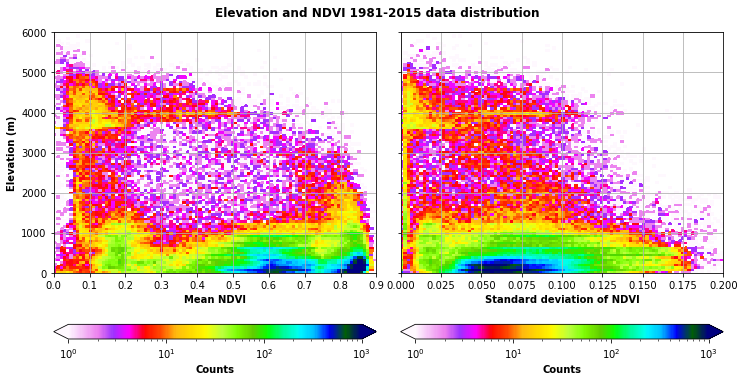

In [14]:
# %%time

# Make figure.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
axes = axes.flatten()

# Means and standard deviation of ndvi at semi-monthly time step.
_, _, _, image = axes[0].hist2d(
    x=DS_NDVI.ndvi.where(DS_NDVI.land_mask==True).mean("time").values.flatten(),
    y=DS_REG.elevation.where(DS_REG.land_mask==True).values.flatten(),
    bins=(100, 100),
    range=[(0.0, 0.9), (0, 6000)],
    cmap=plt.cm.gist_ncar_r,
    norm=mpl.colors.LogNorm(),
    vmin=1,
    vmax=1000,
)  

# Color bar.
cb = plt.colorbar(
    orientation="horizontal",
    mappable=image, 
    ax=axes[0], 
    extend="both"
)
cb.set_label("Counts", weight="bold")

_, _, _, image = axes[1].hist2d(
    x=DS_NDVI.ndvi.where(DS_NDVI.land_mask==True).std("time").values.flatten(),
    y=DS_REG.elevation.where(DS_REG.land_mask==True).values.flatten(),
    bins=(100, 100),
    range=[(0.0, 0.2), (0, 6000)],
    cmap=plt.cm.gist_ncar_r,
    norm=mpl.colors.LogNorm(),
    vmin=1,
    vmax=1000,
)  

# Color bar.
cb = plt.colorbar(
    orientation="horizontal",
    mappable=image, 
    ax=axes[1], 
    extend="both"
)
cb.set_label("Counts", weight="bold")

# Adjustments.
fig.suptitle("Elevation and NDVI 1981-2015 data distribution", weight="bold")
axes[0].set_xlabel("Mean NDVI", weight="bold")
axes[1].set_xlabel("Standard deviation of NDVI", weight="bold")
axes[0].set_ylabel("Elevation (m)", weight="bold")
axes[0].grid(which="both")
plt.subplots_adjust(wspace=0.075, top=0.92)
axes[1].grid(which="both")

if save_fig:
    plt.savefig(
        FIG_FOLDER + "bihistograms_ndvi_elevation.jpg", 
        dpi=100, 
        bbox_inches="tight"
    )